# 確率ロボティクス2016第4回

上田隆一

2016年10月4日@千葉工業大学

## 今日やること

モンテカルロ近似された$bel$にセンサ情報を反映

* 考え方
  * センサの値とパーティクルの姿勢を比較
    * センサの値が得られそうな姿勢のパーティクルは真の姿勢の有力な候補
    * センサの値が得られそうな姿勢のパーティクルはそうでもない
  * 前回使わなかった重みを使用
  
## ランドマークの準備

現在主流はレーザレンジファインダーを使う方法ですが、シミュレーションが大変なので点ランドマークで。

* 点ランドマーク
  * 環境中での絶対位置が分かっている目印
  * ロボットから観測すると、次のことが（曖昧さと共に）分かる
    * どっちの方角に見えるか
    * 距離はどれくらいか

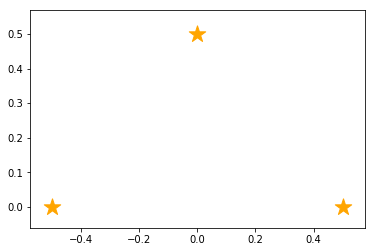

In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

        
actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]

def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
    
draw_landmarks(actual_landmarks)

## ロボットの描画

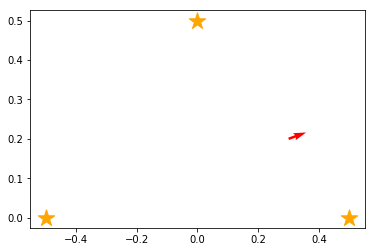

In [2]:
actual_x = np.array([0.3,0.2,math.pi*20.0/180])   #ロボットの実際の姿勢

def draw_robot(pose):
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")
    
draw_robot(actual_x)
draw_landmarks(actual_landmarks)

## 観測モデルの作成

まず、ロボットからランドマークがどの向き、距離に見えるか計算してみましょう。これは、ロボットが360度どこからでも誤差なくランドマークを観測できる時の観測モデルですが、後から制限します。

In [3]:
def relative_landmark_pos(pose,landmark):
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x -lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance, direction)

In [4]:
measurements = [ relative_landmark_pos(actual_x,e) for e in actual_landmarks]
print(measurements)

[(0.8246211251235323, -3.2456798408617948), (0.28284271247461906, -1.1344640137963142), (0.4242640687119285, 2.0071286397934789)]


描画する関数も作成しましょう。

In [5]:
def draw_observation(pose,  measurement):
    x,y,theta = pose
    distance, direction = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    
def draw_observations(pose,  measurements):
    for m in measurements:
        draw_observation(pose, m)

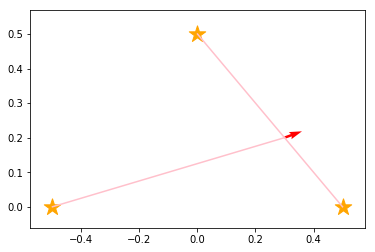

In [6]:
draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x,measurements)

観測モデルを作成します。

* 見える範囲の制限
  * とりあえずロボットから左右90度にしましょう。
* 雑音
  * 距離計測に真値の10%の標準偏差の雑音
  * 方向計測に標準偏差5degの雑音

In [7]:
def observation(pose, landmark):
    actual_distance,actual_direction = relative_landmark_pos(pose,landmark)
    # 方向の制限（cosの値が正）
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance,actual_distance*0.1)  
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)  
    
    return (measured_distance, measured_direction)

def observations(pose,landmarks):
    return filter(lambda x: x != None, [ observation(pose,e) for e in landmarks])

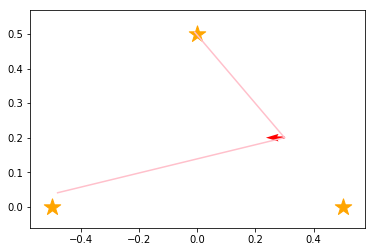

In [8]:
actual_x = np.array([0.3,0.2,math.pi*180.0/180])   #姿勢は変えること
measurements = observations(actual_x, actual_landmarks)

draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x, measurements)

## ロボットを歩行させてみましょう

先週作ったコードに今の観測モデルを載せる。

In [9]:
### クラスや関数のコピペ ###

class Particle:
    def __init__(self,w):
        self.pose = np.array([0.0,0.0,0.0])
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)
        

def f(x_old,u):
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x,pos_y,pos_theta])


def draw(pose,particles):    
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2]) for e in particles]
    vys = [math.sin(e.pose[2]) for e in particles]
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

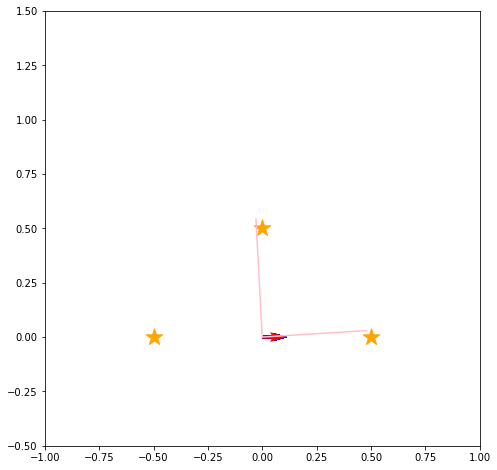

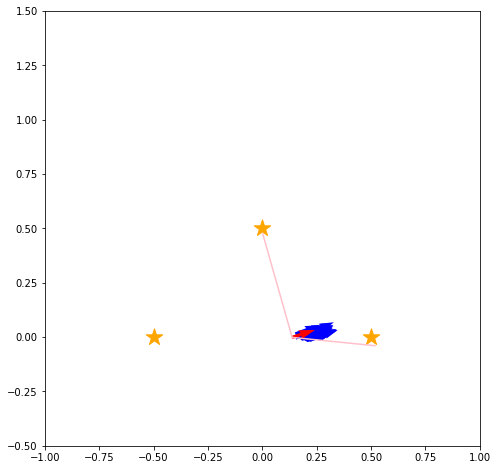

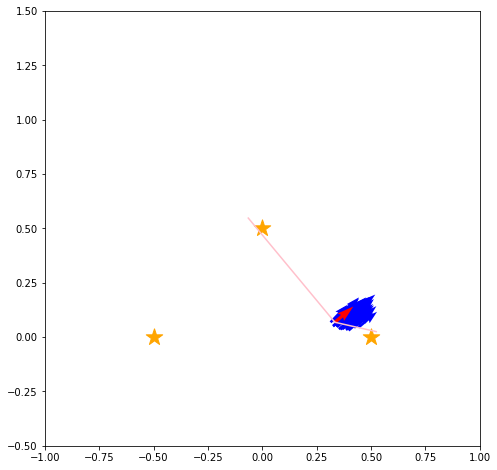

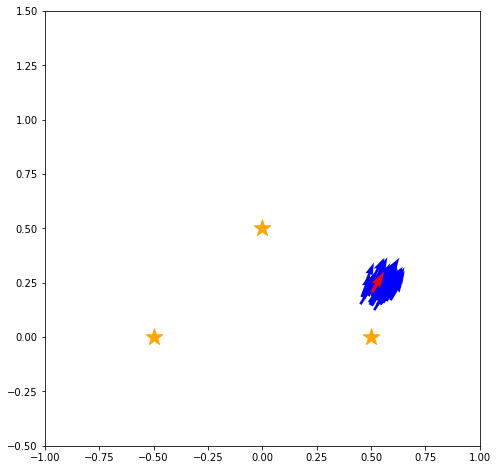

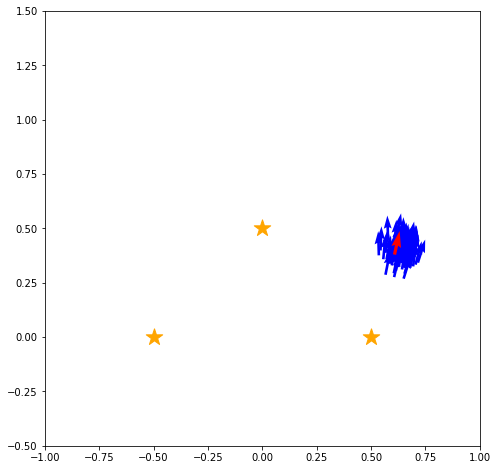

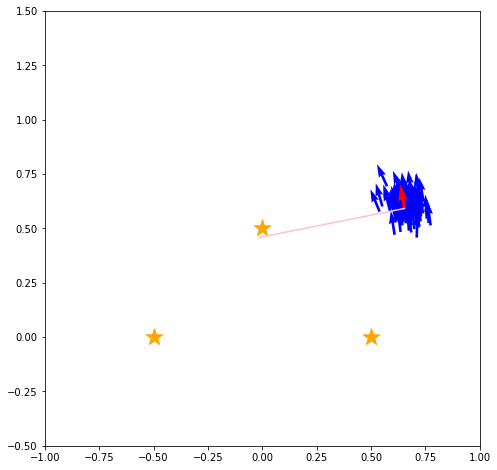

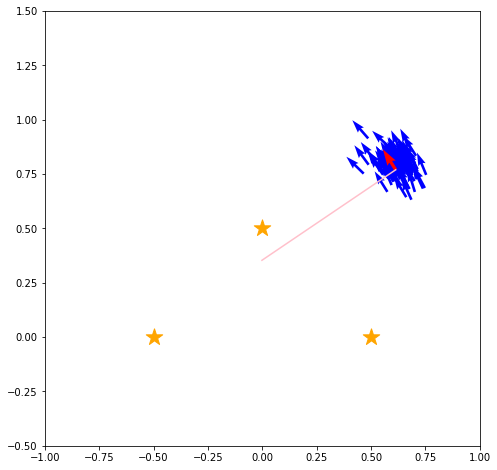

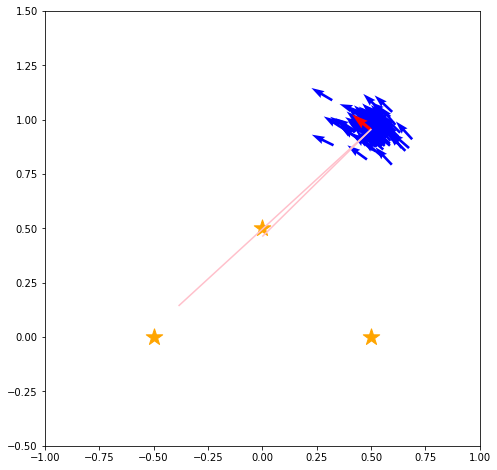

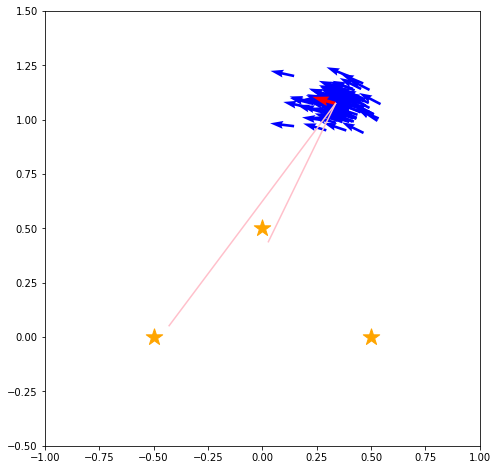

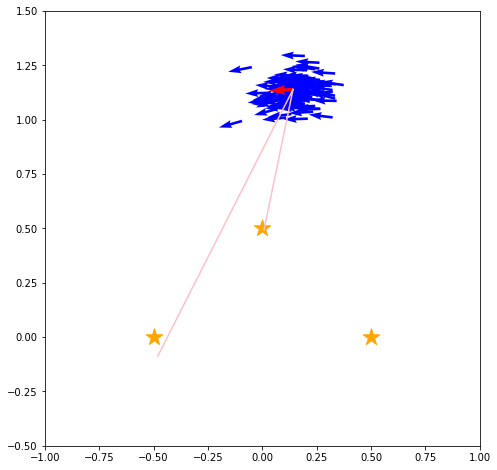

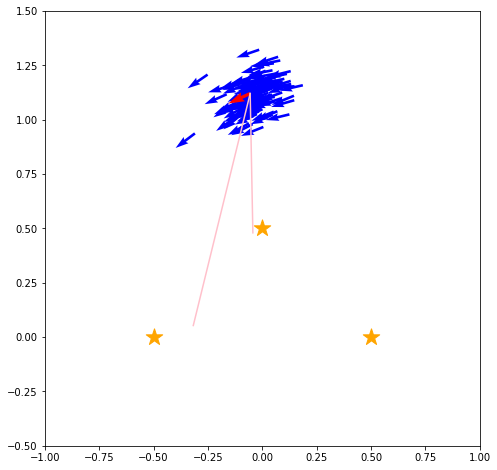

In [10]:
### 行動もコピペベースで。ランドマークの観測と描画を入れる ###

actual_x = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢
particles = [Particle(1.0/100) for i in range(100)]
u = np.array([0.2,math.pi / 180.0 * 20]) #ロボットの移動

import copy

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    measurementss.append(observations(actual_x,actual_landmarks))

    for p in particles:
        p.pose = f(p.pose,u)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])

## 観測をパーティクルに反映